In [2]:
import gdax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from math import ceil
from time import sleep

from backtest import Trader, DoubleTrader, historic_rates
from algorithms import SMA, EMA, MovingAverageAlgo

%matplotlib inline


From: 2018-01-13T07:40:11, To: 2018-01-27T21:40:11
From: 2017-12-29T17:40:11, To: 2018-01-13T07:40:11
From: 2017-12-15T03:40:11, To: 2017-12-29T17:40:11
1008
145.82451651001426
[609.63, 598.75, 599.21, 597.26, 595.97, 598.98, 602.19, 611.04, 610.64, 609.76]


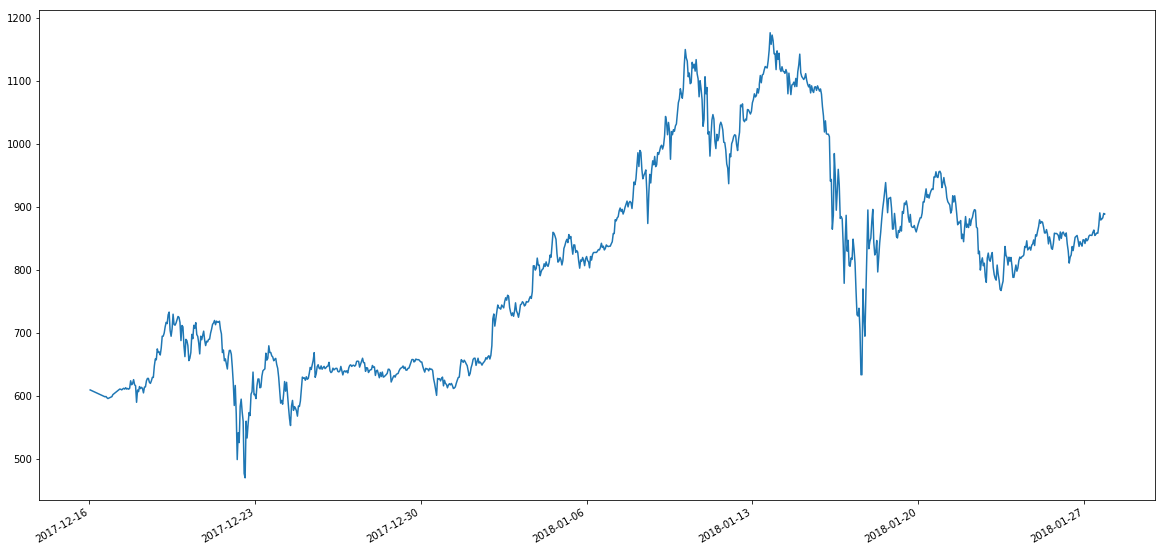

In [3]:
rates = historic_rates('ETH-EUR', 1000, granularity=3600)
prices = [x[4] for x in rates]
while 'a' in prices: prices.remove('a')
times = [x[0] for x in rates]
while 'm' in times: times.remove('m')

prices.reverse()
times.reverse()

print(len(prices))

times_s = pd.Series(times).astype("datetime64[s]")
time_price = pd.Series(prices, times_s)

time_price.plot(figsize=(20,10))
print(prices[-1]/prices[0] * 100)
print(prices[:10])

Backtest Begins Here, loop over combinations of slow and fast Moving average window and calculate profit


In [3]:
trump_win = 200
trump_avg = SMA(trump_win)
trump_algo = MovingAverageAlgo(slow=trump_avg)


In [4]:
# Peform a single run with the optimal parameters from the previous cell
print("Single Run")
from_v = 750
print(prices[-1]/prices[-from_v] * 100)


for slow_win in range(100, 1500, 10):
    slow_avg = SMA(slow_win)

    for price in prices[-(slow_win + from_v):-from_v]:
        slow_avg.tick(price)


    algo = MovingAverageAlgo(slow=slow_avg)
    trader = Trader(algo, verbose=False)
    final = 0 
    for price in prices[-from_v:]:
        final = trader.tick(price)
    print(slow_win, final)

Single Run
137.93269305363765
100 (130.88013073213364, True)
110 (117.9013873052785, True)
120 (128.2544434074459, True)
130 (121.37817162738826, True)
140 (131.7978896385404, True)
150 (133.84579921855826, True)
160 (140.69070399461276, True)
170 (139.992488819814, True)
180 (143.85578544540476, True)
190 (153.53015285522747, True)
200 (146.16250459617285, True)
210 (134.2342665740411, True)
220 (139.00237553875897, True)
230 (146.14431927377228, True)
240 (151.362615188888, True)
250 (148.78211144626246, True)
260 (142.23870483360332, True)
270 (146.52475019157745, True)
280 (143.24589298379777, True)
290 (144.8859860350624, True)
300 (138.72976113596567, True)
310 (134.72892559443892, True)
320 (136.4990588978804, True)
330 (139.43770430438494, False)
340 (139.43770430438494, False)
350 (135.80368484469065, False)
360 (116.65452856986282, False)
370 (118.0045184995805, False)
380 (109.25130028901768, False)
390 (103.79151248131394, False)
400 (95.71084829544283, False)
410 (94.46523

In [8]:
look_back = 750
potential = []
print(prices[-1]/prices[-look_back] * 100)

for tortoise_win in range(250, 251, 1):
    for hare_slow_win in range(20, 40, 2):
        for hare_fast_win in range(2, hare_slow_win, 1):

            tortoise_avg = SMA(tortoise_win)

            for price in prices[-(tortoise_win + look_back):-look_back]:
                tortoise_avg.tick(price)

            tortoise_algo = MovingAverageAlgo(slow=tortoise_avg, 
                                              buy_cutoff=0,          
                                              sell_cutoff=0)

            hare_slow_avg = SMA(hare_slow_win)
            hare_fast_avg = SMA(hare_fast_win)

            for price in prices[-(hare_slow_win + look_back):-look_back]:
                hare_slow_avg.tick(price)

            for price in prices[-(hare_fast_win + look_back):-look_back]:
                hare_fast_avg.tick(price)

            hare_algo = MovingAverageAlgo(slow=hare_slow_avg,
                                          fast=hare_fast_avg)

            trader = DoubleTrader(slow_algo=tortoise_algo,
                            fast_algo=hare_algo,
                            verbose=False)
            final = 0
            stance = False
            for price in prices[-look_back:]:
                final, stance = trader.tick(price)
            potential.append((tortoise_win, hare_fast_win, hare_slow_win, round(final, 2)))
potential.sort(key=lambda tup: tup[3], reverse=True)
for sims in potential[:20]:
    print('{}, {}, {} = {}'.format(*sims))

137.93269305363765
250, 19, 26 = 179.39
250, 8, 24 = 178.61
250, 9, 20 = 177.82
250, 6, 30 = 174.22
250, 8, 26 = 173.63
250, 13, 20 = 173.46
250, 6, 28 = 172.76
250, 7, 32 = 172.58
250, 7, 30 = 172.25
250, 9, 22 = 171.59
250, 8, 30 = 171.54
250, 20, 26 = 171.47
250, 10, 20 = 170.86
250, 12, 20 = 170.41
250, 7, 24 = 170.36
250, 12, 30 = 169.91
250, 11, 32 = 169.64
250, 13, 30 = 169.45
250, 10, 34 = 169.15
250, 12, 36 = 168.79


In [ ]:
def backtest(slow, fast, look_back, prices):
    assert(len(prices) >= slow + look_back)
    slow_avg = EMA(slow)
    fast_avg = SMA(fast)

    for price in prices[-(slow + look_back):-look_back]:
        slow_avg.tick(price)

    for price in prices[-(fast + look_back):-look_back]:
        fast_avg.tick(price)

    algo = MovingAverageAlgo(slow=slow_avg, 
                             fast=fast_avg,   
                             buy_cutoff=0.0,          
                             sell_cutoff=0.0)
    trader = Trader(algo, 
                    fee=0.0, 
                    trade_prob=1.0,
                    verbose=False)
    final = 0
    stance = False
    for price in prices[-look_back:]:
        final, stance = trader.tick(price)
    return final, stance, trader.num_trades
    
    

In [ ]:
def backtest_algo(look_back, top_win, prices, verbose=False):
    potential = []
    votes = []
    num_voters = 3

    for slow in range (2, top_win, 1):
        for fast in range(1, slow, 1):
            final, stance, num_trades = backtest(slow=slow, fast=fast, look_back=look_back, prices=prices)
            potential.append((fast, slow, final/buy_hold, final, num_trades, buy_hold, stance))
    potential.sort(key=lambda tup: tup[3], reverse=True)
    for sims in potential[:3]:
        if verbose: print("{} - {}: {}x [{}] ({}) [{}] {}".format(*sims))
        votes.append(sims[6])
    return (sum(votes) / num_voters) > 0.5


In [ ]:
class AdaptiveAlgo:
    def __init__(self, look_back, top_win, prices, verbose=False):
        self.look_back = look_back
        self.top_win = top_win
        self.prices = np.array(prices)
        self.verbose=verbose
        
    def tick(self, price):
        self.prices = np.roll(self.prices, -1)
        self.prices[-1] = price
        return backtest_algo(look_back=self.look_back, 
                             top_win=self.top_win, 
                             prices=self.prices, 
                             verbose=self.verbose)
        

In [ ]:
print(prices[-50]/prices[-1])

In [ ]:
top_win = 48
far_back = -48

print(prices[far_back]/prices[-1])

ada_algo = AdaptiveAlgo(look_back=top_win, 
                        top_win=top_win, 
                        prices=prices[far_back-(2*top_win):far_back], 
                        verbose=False)
trader = Trader(ada_algo, verbose=False)
for price in prices[far_back:-1]:
    print("Price: {}, Value: {}, Stance: {}".format(price, *trader.tick(price)))

In [ ]:
potential = []
from_v = 48

votes = []
num_voters = 3

for slow in range (2, 72, 1):
    for fast in np.arange(1, slow, 1):
        final, stance, num_trades = backtest(slow=slow, fast=fast, look_back=from_v, prices=prices)
        buy_hold = prices[-1]/prices[from_v] * 100
        potential.append((fast, slow, final/buy_hold, final, num_trades, buy_hold, stance))
potential.sort(key=lambda tup: tup[3], reverse=True)
for sims in potential[:3]:
    print("{} - {}: {}x [{}] ({}) [{}] {}".format(*sims))
    votes.append(sims[6])
print(sum(votes))


In [ ]:
# Peform a single run with the optimal parameters from the previous cell
print("Single Run")

slow_win = potential[0][1]
fast_win = potential[0][0]

slow_avg = EMA(slow_win)
fast_avg = SMA(fast_win)

for price in prices[-(slow_win + from_v):-from_v]:
    slow_avg.tick(price)
    
for price in prices[-(fast_win + from_v):-from_v]:
    fast_avg.tick(price)


algo = MovingAverageAlgo(slow=slow_avg, 
                         fast=fast_avg,   
                         buy_cutoff=0,          
                         sell_cutoff=0)
trader = Trader(algo, verbose=True)
for price in prices[-from_v:]:
    trader.tick(price)

In [ ]:
# Grid search for optimal offsets
potential = []
for b_offset in np.arange(-0.0028, -0.0026, 0.00001):
    for s_offset in np.arange(-0.0026, -0.0024, 0.00001):
        #print("{}, {}".format(fast, slow))
        b_offset = round(b_offset, 5)
        s_offset = round(s_offset, 5)

        slow_avg = EMA(23)
        fast_avg = SMA(16)
        algo = MovingAverageAlgo(slow=slow_avg, 
                                 fast=fast_avg,   
                                 buy_cutoff=b_offset,          
                                 sell_cutoff=s_offset)
        trader = Trader(algo, 
                        fee=0.0, 
                        trade_prob=0.9)
        final = 0
        for price in prices:
            final = trader.tick(price)
        buy_hold = prices[-1]/prices[slow] * 100
        if final >= prices[-1]/prices[slow] * 100:
        #if final > 100.0:
            potential.append((final, b_offset, s_offset))
            print("{} - {}: {}x [{}] ({}) [{}]".format(b_offset, s_offset, final/buy_hold, final, trader.num_trades, buy_hold))
potential.sort(key=lambda tup: tup[0], reverse=True)
print(potential)


In [ ]:
slow_vals = []
fast_vals = []
signals = []

slow_v = 7
fast_v = 4

slow = EMA(slow_v)
fast = SMA(fast_v)
slow_avg = EMA(slow_v)
fast_avg = SMA(fast_v)
algo = MovingAverageAlgo(slow=slow_avg, 
                         fast=fast_avg,   
                         buy_cutoff=0,          
                         sell_cutoff=0)
for price in prices:
    slow_vals.append(slow.tick(price))
    fast_vals.append(fast.tick(price))
    signals.append(1 if algo.tick(price) else 0)


In [ ]:
print(prices[-from_v:])
print(signals[-from_v:])
print(slow_vals[-from_v:])
print(fast_vals[-from_v:])
plt.plot(prices[-from_v:])
plt.plot(slow_vals[-from_v:])
plt.plot(fast_vals[-from_v:])

In [ ]:
a = [1,2,3,4]
a[-3:-2]

In [ ]:
plt.plot(prices[-from_v:])
plt.plot(slow_vals[-from_v:])
plt.plot(fast_vals[-from_v:])

from_v = 12
slow_win = 23
fast_win = 16

slow_avg = EMA(slow_win)
fast_avg = SMA(fast_win)

for price in prices[-(slow_win + from_v):-from_v]:
    slow_avg.tick(price)
    
for price in prices[-(fast_win + from_v):-from_v]:
    fast_avg.tick(price)


algo = MovingAverageAlgo(slow=slow_avg, 
                         fast=fast_avg,   
                         buy_cutoff=0,          
                         sell_cutoff=0)
trader = Trader(algo)
for price in prices[-from_v:]:
    trader.tick(price)


In [ ]:
fast = 1
slow = 2

mvag_fast = time_price.rolling(window=fast,center=False).mean()
mvag_slow = time_price.rolling(window=slow,center=False).mean()

time_price.tail(100).plot(figsize=(20,10))
mvag_fast.tail(100).plot(figsize=(20,10))
mvag_slow.tail(100).plot(figsize=(20,10))

In [ ]:
emvag_fast = time_price.ewm(span=fast, adjust=False).mean()
emvag_slow = time_price.ewm(span=slow, adjust=False).mean()

time_price.tail(100).plot(figsize=(20,10))
emvag_fast.tail(100).plot(figsize=(20,10))
emvag_slow.tail(100).plot(figsize=(20,10))

In [ ]:
window = 200
e = EMA(window)
s = SMA(window * 2)
ema_test = []
sma_test = []
for price in prices:
    ema_test.append(e.tick(price))
    sma_test.append(s.tick(price))

ema_test = ema_test[window-1:]
sma_test = sma_test[(window * 2)-1:]

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)

plt.plot(prices[window:])
plt.plot(ema_test)
plt.plot(sma_test)